In [37]:
# Not subclassing prevents using different behaviour in training and in generation. Means dropout is not an option.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import scipy
from sklearn import preprocessing

%matplotlib inline

In [39]:
# Get in dataset
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed.csv", sep=",")

In [40]:
attacks = preprocessing.normalize(attacks.to_numpy()[:, 1:], norm="max", axis=0)

In [41]:
seq_length = 10
batch_size = 64
num_features = attacks.shape[1]
codings_size = 100

In [42]:
# train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:9984]).shuffle(10000).batch(batch_size))
# test_dataset = attacks[attacks.shape[0]-5000:]

In [43]:
# should probably add batch and shuffle

train_dataset = attacks[:int(np.floor(attacks.shape[0]*4/5))]
test_dataset = attacks[int(np.floor(attacks.shape[0]*4/5)):]

train_dataset = train_dataset[:20000]

# buffer_size = 10000
# batch_size = 50

# train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:int(np.floor(attacks.shape[0]*3/4))]).shuffle(buffer_size).batch(batch_size))
# test_dataset = (tf.data.Dataset.from_tensor_slices(attacks[int(np.floor(attacks.shape[0]*3/4)):]).shuffle(buffer_size).batch(batch_size))

In [44]:
train_dataset.shape, test_dataset.shape

((20000, 22), (531634, 22))

In [45]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [46]:
# encoder

inputs = tf.keras.layers.Input(shape=[num_features,1])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(z)
z = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(z)
codings_mean = tf.keras.layers.Dense(codings_size)(z) # mu
codings_log_var = tf.keras.layers.Dense(codings_size)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [47]:
# decoder

decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(num_features*1, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([num_features, 1])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [48]:
# VAE model

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [49]:
# losses

latent_loss = -0.5 * tf.keras.backend.sum(1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss / float(num_features)))
# variational_ae.add_loss(tf.keras.backend.mean(latent_loss))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
variational_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [50]:
history = variational_ae.fit(train_dataset, train_dataset, epochs=50, batch_size=64)

Epoch 1/50
313/313 [==============================] - 1s 963us/step - loss: 0.9102
Epoch 2/50
313/313 [==============================] - 0s 937us/step - loss: 0.6571
Epoch 3/50
313/313 [==============================] - 0s 954us/step - loss: 0.4905
Epoch 4/50
313/313 [==============================] - 0s 960us/step - loss: 0.3827
Epoch 5/50
313/313 [==============================] - 0s 952us/step - loss: 0.3122
Epoch 6/50
313/313 [==============================] - 0s 949us/step - loss: 0.2695
Epoch 7/50
313/313 [==============================] - 0s 952us/step - loss: 0.2462
Epoch 8/50
313/313 [==============================] - 0s 954us/step - loss: 0.2327
Epoch 9/50
313/313 [==============================] - 0s 950us/step - loss: 0.2246
Epoch 10/50
313/313 [==============================] - 0s 958us/step - loss: 0.2194
Epoch 11/50
313/313 [==============================] - 0s 958us/step - loss: 0.2162
Epoch 12/50
313/313 [==============================] - 0s 976us/step - loss: 0.2141
E

Text(0, 0.5, 'Loss')

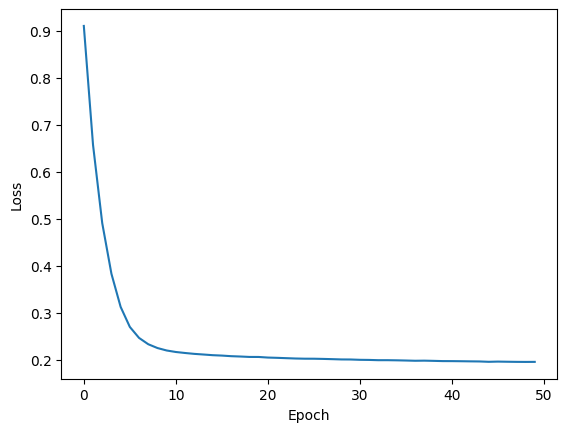

In [51]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.savefig("vae_wustl.png", dpi=800)

In [52]:
# vae_loss_history["wustl"] = history.history["loss"]

In [53]:
# vae_loss_history

In [54]:
# vae_loss_history = {"swat_network": None, "swat_sensor": None, "wadi": None, "wustl": None}

In [55]:
# plt.figure()
# plt.plot(vae_loss_history["swat_sensor"], label="SWaT sensor data")
# plt.plot(vae_loss_history["swat_network"], label="SWaT network data")
# plt.plot(vae_loss_history["wadi"], label="WADI sensor data")
# plt.plot(vae_loss_history["wustl"], label="WUSTL network data")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# # plt.show()
# plt.savefig("vae_losses.png")

In [56]:
predictions = variational_ae.predict(test_dataset)

num_values = test_dataset.shape[0] * test_dataset.shape[1]

scipy.stats.ks_2samp(test_dataset.reshape(num_values,), predictions.reshape(num_values,))

16614/16614 [==============================] - 10s 597us/step


KstestResult(statistic=0.4158826629530159, pvalue=0.0, statistic_location=5.8609572999999995e-05, statistic_sign=1)

In [57]:
scipy.stats.ks_2samp(test_dataset.reshape(num_values,), train_dataset.reshape(train_dataset.shape[0] * train_dataset.shape[1]))

KstestResult(statistic=0.009499702709006574, pvalue=1.1444612541920637e-33, statistic_location=3.8812443e-05, statistic_sign=-1)

In [58]:
predictions.shape

(531634, 22, 1)

In [59]:
predictions.reshape(predictions.shape[0], predictions.shape[1]).shape

(531634, 22)

In [60]:
# df = pd.DataFrame(predictions.reshape(predictions.shape[0], predictions.shape[1]))
# df.to_csv("vae_swat_sensor.csv", index=False)